# Style Transfer

[VGG Model](https://medium.com/@siddheshb008/vgg-net-architecture-explained-71179310050f)    
[Paper for VGG Model](https://arxiv.org/pdf/1409.1556)    
  
Freezes the VGG layers  
Sends the original image, the syle image and the image to be modified into the VGG   
Measures a content and style loss at 5 different layers of the VGG with different weights  
   
The content loss is an MSE Loss   
The style loss is computed using a Gram Matrix

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import make_grid

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
    print(device)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')
mps


In [3]:
model=models.vgg19(pretrained=True).features
print(model)

l=[0,5,10,19,28]

/Users/shvetang/ENTER/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/shvetang/ENTER/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
image_size=64
loader=transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor()
    ]
)

In [5]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()

        self.chosen_features = l
        self.model=models.vgg19(pretrained=True).features[:29]

    def forward(self,x):
        features=[]
        for idx, layer in enumerate(self.model):
            x=layer(x)
            
            if idx in self.chosen_features:
                features.append(x)
        return features

In [6]:
def load_image(image_name):
    image=Image.open(image_name)
    image=loader(image).unsqueeze(0)
    return image.to(device)

In [7]:
original=load_image("model.jpg")
style=load_image("style.jpg")

generated=original.clone().requires_grad_(True)

In [8]:
total_steps = 60
lr = 0.001
alpha=1
beta=0.01

In [9]:
optimizer=optim.Adam([generated],lr=lr)
model=VGG().to(device).eval()

original_features=model(original)
style_features=model(style)

loss=[]
batch=[]

In [10]:
for step in range(total_steps):
    generated_features=model(generated)

    content_loss=style_loss=0
    
    for g, o, s in zip(
        generated_features,original_features,style_features
    ):
        batch_size, channel, height, width = g.shape
        content_loss+= torch.mean((g-o)**2)
        
        G = g.view(channel,height*width).mm(
            g.view(channel,height*width).t()
        )
        S = s.view(channel,height*width).mm(
            s.view(channel,height*width).t()
        )
        style_loss+= torch.mean((G-S)**2)
    
    total_loss = alpha*content_loss + beta*style_loss
    optimizer.zero_grad()
    total_loss.backward(retain_graph=True)
    optimizer.step()

    if (step+1)%3==0:
        batch.append(generated)
        loss.append(round(total_loss.item(),2))
        print(f"{step+1} completed")

3 completed
6 completed
9 completed
12 completed
15 completed
18 completed
21 completed
24 completed
27 completed
30 completed
33 completed
36 completed
39 completed
42 completed
45 completed
48 completed
51 completed
54 completed
57 completed
60 completed


In [11]:
print(len(batch))
print(len(loss))

20
20


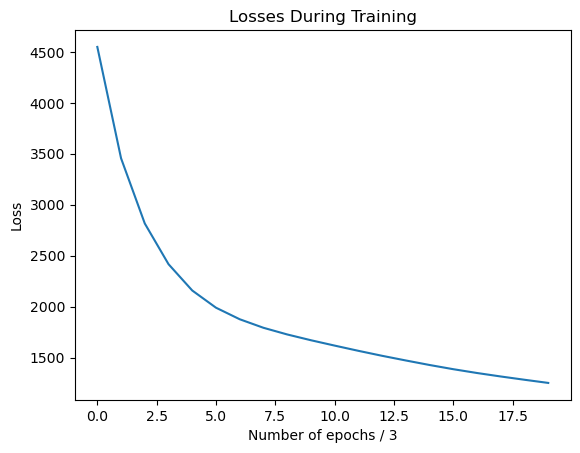

In [12]:
plt.plot(loss)
plt.xlabel("Number of epochs / 3")
plt.ylabel("Loss")
plt.title("Losses During Training")
plt.show()

In [13]:
def plot_images(image_list):
    # Create a figure with a 4x5 grid of subplots
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))

    # Flatten axes to easily iterate over them
    axes = axes.ravel()

    for i in range(20):
        # Convert PyTorch tensor to NumPy array if needed (assuming tensors are in [C, H, W])
        # If your images are in tensor format (torch.Tensor), you may need to convert them.
        # If they're already in NumPy format, you can skip this step.
        image = image_list[i].cpu().detach().squeeze().numpy().transpose(1, 2, 0)

        # Plot the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Hide the axis

    # Show the plot
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

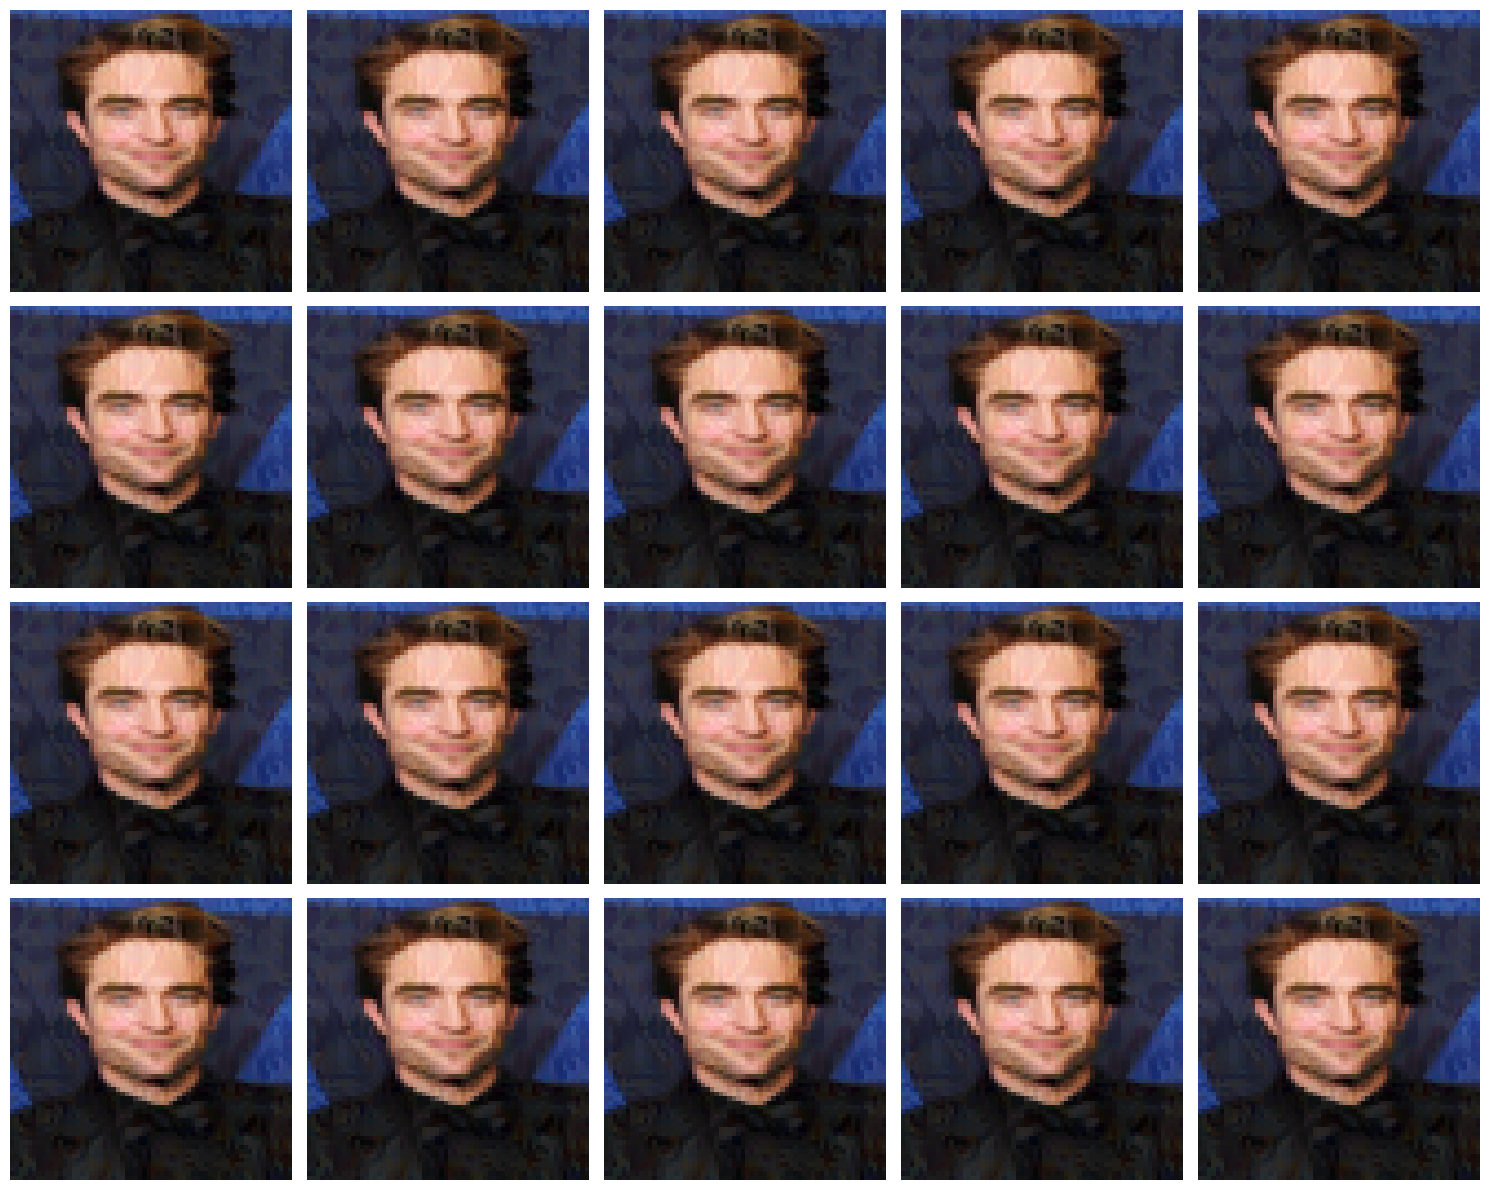

In [14]:
plot_images(batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 64, 3)


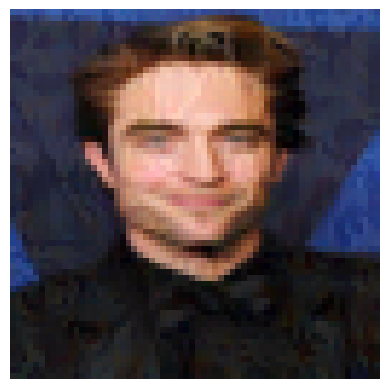

In [16]:
img=batch[19].cpu().detach().squeeze().numpy().transpose(1,2,0)
print(img.shape)
plt.imshow(img)
plt.axis('off')
plt.show()